In [1]:
# Global constants
ZIP_PATH = "/content/drive/MyDrive/data.zip"
NIFTI_ZIP_PATH = "/content/drive/MyDrive/369Seg_Masks_nii.zip"
H5_FILES_PREFIX = 'data/volume_'
H5_FILES_SUFFIX = '.h5'
MAX_SAMPLES = 100
EPOCHS = 50
IMG_HEIGHT, IMG_WIDTH = 240, 240
VOLUME_SLICES = 110 # it should be 110
VOLUME_START_AT = 22 # it must be 22
MODALITIES = ["FLAIR", "T2", "T1ce", "T1"]
MODALITY_INDICES = {"T1": 3, "T1ce": 2, "T2": 1, "FLAIR": 0}
CLASS_LABELS = {0: "Background", 1: "Non-enhancing Tumor", 2: "Edema", 3: "Enhancing Tumor"}
METRIC_LABELS = {"WT": "Whole Tumor", "ET": "Enhancing Tumor", "TC": "Tumor Core"}
SAVE_PATH_MODEL = "/content/drive/MyDrive/optimized_dr_unet_model_soft_dice.keras"
BATCH_SIZE = 4 # it must be 4
PATIENCE = 5 # it must be 5


In [4]:
# Step 1: Install Dependencies
!pip install nibabel matplotlib tensorflow opencv-python medpy scikit-image -q

import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from medpy.metric.binary import hd95, dc
import zipfile
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib
import cv2
import nibabel as nib
import gc
from google.colab import drive
import pandas as pd

# Enable mixed precision to optimize performance and reduce memory usage
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [5]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Verify ZIP files
if not os.path.exists(ZIP_PATH):
    raise FileNotFoundError(f"ZIP file not found at {ZIP_PATH}")
if not os.path.exists(NIFTI_ZIP_PATH):
    raise FileNotFoundError(f"NIfTI ZIP file not found at {NIFTI_ZIP_PATH}")

In [7]:
# Step 2: Define Metrics and Loss
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])  # Sum over H, W, C
    true_sum = tf.reduce_sum(y_true, axis=[1, 2, 3])
    pred_sum = tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (true_sum + pred_sum + smooth)
    return 1 - tf.reduce_mean(dice)  # Loss = 1 - mean Dice

In [8]:
# Step 3: Squeeze-and-Excitation Block
def se_block(input_tensor, ratio=8):
    filters = tf.keras.backend.int_shape(input_tensor)[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal')(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal')(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.Multiply()([input_tensor, se])

In [9]:
# Step 4: Residual and Bottleneck Blocks
def residual_block(x, filters, dropout_rate=0.2):
    input_filters = tf.keras.backend.int_shape(x)[-1]
    shortcut = layers.Conv2D(filters, (1, 1), padding='same')(x) if input_filters != filters else x
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    return layers.Add()([shortcut, x])

def bottleneck_block(x, filters, stride=1, dropout_rate=0.2):
    input_filters = tf.keras.backend.int_shape(x)[-1]
    shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters // 4, (1, 1), strides=stride, padding='same')(x)
    x = layers.Conv2D(filters // 4, (3, 3), padding='same')(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = se_block(x)
    return layers.Add()([x, shortcut])

In [10]:
# Step 5: DR-Unet Architecture
def optimized_dr_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 2), dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)
    e1 = bottleneck_block(inputs, 32, dropout_rate=dropout_rate)
    e2 = bottleneck_block(e1, 64, stride=2, dropout_rate=dropout_rate)
    e3 = bottleneck_block(e2, 128, stride=2, dropout_rate=dropout_rate)
    e4 = bottleneck_block(e3, 256, stride=2, dropout_rate=dropout_rate)
    b = bottleneck_block(e4, 256, dropout_rate=dropout_rate)
    d4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    d4 = layers.Concatenate()([d4, e3])
    d4 = residual_block(d4, 128, dropout_rate=dropout_rate)
    d3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d4)
    d3 = layers.Concatenate()([d3, e2])
    d3 = residual_block(d3, 64, dropout_rate=dropout_rate)
    d2 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(d3)
    d2 = layers.Concatenate()([d2, e1])
    d2 = residual_block(d2, 32, dropout_rate=dropout_rate)
    outputs = layers.Conv2D(4, (1, 1), activation='softmax', dtype='float32')(d2)
    return models.Model(inputs, outputs)

In [11]:
# Step 6: Preload Data to Memory
def preload_data(patient_ids, zip_path, nifti_zip_path, dim=(IMG_HEIGHT, IMG_WIDTH)):
    data = {}
    for pid in patient_ids:
        data[pid] = {'images': [], 'masks': []}
        with zipfile.ZipFile(nifti_zip_path, 'r') as nifti_zip_ref:
            nifti_file = f"369Seg_Masks_nii/BraTS20_Training_{int(pid):03d}_seg.nii"
            with nifti_zip_ref.open(nifti_file) as f:
                mask = nib.Nifti1Image.from_bytes(f.read()).get_fdata().astype(np.uint8)

        valid_slices = []
        for j in range(VOLUME_SLICES):
            slice_idx = j + VOLUME_START_AT
            if slice_idx >= mask.shape[2]:
                continue
            mask_slice = mask[:, :, slice_idx]
            if np.any(np.isin(mask_slice, [1, 2, 3, 4])):  # Tumor present
                valid_slices.append(j)

        # Preallocate arrays
        num_slices = len(valid_slices)
        images = np.zeros((num_slices, dim[0], dim[1], 2), dtype=np.float16)
        masks = np.zeros((num_slices, dim[0], dim[1], 4), dtype=np.float16)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            for i, j in enumerate(valid_slices):
                slice_idx = j + VOLUME_START_AT
                h5_file = f"{H5_FILES_PREFIX}{pid}_slice_{slice_idx}{H5_FILES_SUFFIX}"
                if h5_file in zip_ref.namelist():
                    with zip_ref.open(h5_file) as f:
                        with h5py.File(BytesIO(f.read()), 'r') as hf:
                            img = hf['image'][:]
                    img_slice = img[:, :, [MODALITY_INDICES["FLAIR"], MODALITY_INDICES["T1ce"]]]
                    img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + 1e-8)
                    img_slice = cv2.resize(img_slice, dim)
                    mask_slice = mask[:, :, slice_idx]
                    mask_slice[mask_slice == 4] = 3
                    onehot_mask = to_categorical(mask_slice, num_classes=4)
                    onehot_mask = cv2.resize(onehot_mask, dim)
                    images[i] = img_slice
                    masks[i] = onehot_mask

        data[pid]['images'] = images
        data[pid]['masks'] = masks

    return data

In [12]:
# Step 7: Create tf.data Dataset
def create_dataset(patient_ids, preloaded_data, batch_size, shuffle=True):
    def gen():
        for pid in patient_ids:
            images = preloaded_data[pid]['images']
            masks = preloaded_data[pid]['masks']
            indices = np.arange(len(images))
            if shuffle:
                np.random.shuffle(indices)
            for idx in indices:
                yield images[idx], masks[idx]

    dataset = tf.data.Dataset.from_generator(
        generator=gen,
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 2), dtype=tf.float16),
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 4), dtype=tf.float16)
        )
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [13]:
# Step 8: Load and Split Patient IDs
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    filenames = [f for f in zip_ref.namelist() if f.startswith(H5_FILES_PREFIX) and f.endswith(H5_FILES_SUFFIX)]
    patient_ids = sorted(list(set(f.split('/')[-1].split('_')[1] for f in filenames if 'slice' in f)))[:MAX_SAMPLES]

train_ids, temp_ids = train_test_split(patient_ids, train_size=0.7, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.333, random_state=42)

print(f"Patient Split: {len(train_ids)} train ({len(train_ids)/len(patient_ids):.2%}), "
      f"{len(val_ids)} validation ({len(val_ids)/len(patient_ids):.2%}), "
      f"{len(test_ids)} test ({len(test_ids)/len(patient_ids):.2%})")
print(f"Train IDs: {train_ids}")
print(f"Validation IDs: {val_ids}")
print(f"Test IDs: {test_ids}")

# Preload data
print("Preloading data...")
preloaded_data = preload_data(patient_ids, ZIP_PATH, NIFTI_ZIP_PATH)
train_dataset = create_dataset(train_ids, preloaded_data, BATCH_SIZE, shuffle=True)
val_dataset = create_dataset(val_ids, preloaded_data, BATCH_SIZE, shuffle=False)
test_dataset = create_dataset(test_ids, preloaded_data, BATCH_SIZE, shuffle=False)

Patient Split: 70 train (70.00%), 20 validation (20.00%), 10 test (10.00%)
Train IDs: ['109', '141', '176', '124', '183', '103', '159', '158', '130', '113', '143', '13', '105', '185', '123', '116', '172', '121', '155', '110', '120', '101', '114', '133', '106', '17', '104', '157', '131', '18', '15', '189', '148', '138', '144', '16', '140', '160', '154', '187', '170', '136', '151', '142', '188', '150', '167', '128', '184', '152', '156', '175', '132', '125', '10', '146', '118', '100', '12', '178', '181', '166', '177', '173', '117', '153', '163', '111', '182', '145']
Validation IDs: ['139', '168', '134', '129', '126', '122', '147', '162', '112', '14', '179', '135', '11', '164', '149', '171', '115', '180', '127', '119']
Test IDs: ['186', '102', '137', '169', '108', '1', '107', '161', '165', '174']
Preloading data...


In [14]:
# Step 9: Build and Compile Model
model = optimized_dr_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 2))
base_optimizer = optimizers.Adam(learning_rate=1e-4)
#optimizer = mixed_precision.LossScaleOptimizer(base_optimizer)
model.compile(
    optimizer = base_optimizer,
    loss=soft_dice_loss,
    metrics=['accuracy', dice_coef]
)

In [15]:


# Step 10: Set up Callbacks
callbacks = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    callbacks.ModelCheckpoint(SAVE_PATH_MODEL, save_best_only=True, verbose=1),
    callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True),
    TqdmCallback(verbose=1)
]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [16]:
# Step 11: Train Model
tf.keras.backend.clear_session()
try:
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=0
    )
except Exception as e:
    print(f"Training error: {str(e)}")
    # Fallback to BATCH_SIZE=1
    BATCH_SIZE = 1
    train_dataset = create_dataset(train_ids, preloaded_data, BATCH_SIZE, shuffle=True)
    val_dataset = create_dataset(val_ids, preloaded_data, BATCH_SIZE, shuffle=False)
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=0
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.01846, saving model to /content/drive/MyDrive/optimized_dr_unet_model_soft_dice.keras

Epoch 2: val_loss improved from 0.01846 to 0.01413, saving model to /content/drive/MyDrive/optimized_dr_unet_model_soft_dice.keras

Epoch 3: val_loss did not improve from 0.01413

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 4: val_loss did not improve from 0.01413

Epoch 5: val_loss improved from 0.01413 to 0.01282, saving model to /content/drive/MyDrive/optimized_dr_unet_model_soft_dice.keras

Epoch 6: val_loss did not improve from 0.01282

Epoch 7: val_loss improved from 0.01282 to 0.01177, saving model to /content/drive/MyDrive/optimized_dr_unet_model_soft_dice.keras

Epoch 8: val_loss did not improve from 0.01177

Epoch 9: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 9: val_loss did not improve from 0.01177

Epoch 10: val_loss did not improve from 0.01177

Epoch 11: ReduceLROnPlateau redu

In [17]:
# Save final model
model.save(SAVE_PATH_MODEL)

In [18]:
# Step 12: Evaluate Model with DSC/HD95 for WT, ET, TC
def evaluate_model(dataset):
    results = {"WT": {"DSC": [], "HD95": []}, "ET": {"DSC": [], "HD95": []}, "TC": {"DSC": [], "HD95": []}}
    for X, y_true in dataset:
        y_pred = model.predict(X, verbose=0)
        y_pred = np.argmax(y_pred, axis=-1)
        y_true = np.argmax(y_true, axis=-1)
        for j in range(y_true.shape[0]):
            for metric in ["WT", "ET", "TC"]:
                if metric == "WT":
                    pred_bin = (y_pred[j] > 0).astype(np.uint8)
                    true_bin = (y_true[j] > 0).astype(np.uint8)
                elif metric == "ET":
                    pred_bin = (y_pred[j] == 3).astype(np.uint8)
                    true_bin = (y_true[j] == 3).astype(np.uint8)
                elif metric == "TC":
                    pred_bin = np.isin(y_pred[j], [1, 3]).astype(np.uint8)
                    true_bin = np.isin(y_true[j], [1, 3]).astype(np.uint8)
                if np.sum(true_bin) > 0:
                    results[metric]["DSC"].append(dc(pred_bin, true_bin))
                    try:
                        results[metric]["HD95"].append(hd95(pred_bin, true_bin))
                    except:
                        results[metric]["HD95"].append(np.nan)
    return {
        "WT": {"DSC": np.mean(results["WT"]["DSC"]) if results["WT"]["DSC"] else 0.0,
               "HD95": np.nanmean(results["WT"]["HD95"]) if results["WT"]["HD95"] else np.nan},
        "ET": {"DSC": np.mean(results["ET"]["DSC"]) if results["ET"]["DSC"] else 0.0,
               "HD95": np.nanmean(results["ET"]["HD95"]) if results["ET"]["HD95"] else np.nan},
        "TC": {"DSC": np.mean(results["TC"]["DSC"]) if results["TC"]["DSC"] else 0.0,
               "HD95": np.nanmean(results["TC"]["HD95"]) if results["TC"]["HD95"] else np.nan}
    }

# Evaluate on validation and test sets
val_metrics = evaluate_model(val_dataset)
test_metrics = evaluate_model(test_dataset)

# Display results
results_df = pd.DataFrame({
    'Set': ['Validation', 'Test'],
    'WT_DSC': [val_metrics['WT']['DSC'], test_metrics['WT']['DSC']],
    'ET_DSC': [val_metrics['ET']['DSC'], test_metrics['ET']['DSC']],
    'TC_DSC': [val_metrics['TC']['DSC'], test_metrics['TC']['DSC']],
    'WT_HD95': [val_metrics['WT']['HD95'], test_metrics['WT']['HD95']],
    'ET_HD95': [val_metrics['ET']['HD95'], test_metrics['ET']['HD95']],
    'TC_HD95': [val_metrics['TC']['HD95'], test_metrics['TC']['HD95']],
})

print("\nEvaluation Results:")
print(results_df)


Evaluation Results:
          Set    WT_DSC    ET_DSC    TC_DSC    WT_HD95    ET_HD95    TC_HD95
0  Validation  0.750610  0.693860  0.696628  19.918962  10.802384  12.986242
1        Test  0.793397  0.787435  0.808590  16.561999   5.404485   6.940695


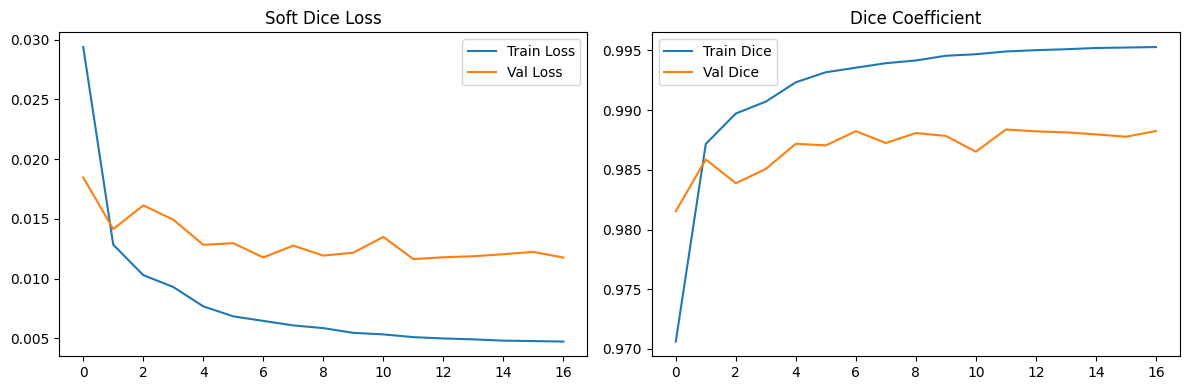

In [19]:
# Step 13: Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Soft Dice Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Clean up
tf.keras.backend.clear_session()
gc.collect()

0